In [5]:
import rpyc
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [ ]:
conn = rpyc.classic.connect("ev3dev.local") # host name or IP address of the EV3
ev3 = conn.modules['ev3dev2']      # import ev3dev2.ev3 remotely

legosensors=conn.modules['ev3dev2.sensor.lego']
sensor_controls=conn.modules['ev3dev2.sensor']
motor=conn.modules['ev3dev2.motor']
m = motor.LargeMotor("outA")

out1=sensor_controls.INPUT_1
out2=sensor_controls.INPUT_2

touch = legosensors.TouchSensor(out1)
touchstop = legosensors.TouchSensor(out2)


This is two experiments to check the response speed of the robots.  
First, the response speed of the sensors, and second, the response speed of the motors.

# Sensor response experiment
Setup: A button connected to the brick.

In [ ]:
reactlist=[]
for _ in range(1000):

    past=time.clock()
    while True:
        if not touch.is_pressed:

            reactlist.append(time.clock()-past)
            break

# Motor response experiment
Setup: A motor with an arm, hitting a button, see below.
![Experiment](./Motor_react_speed.gif)

In [ ]:
def useless():
    past=time.clock()
    stop=0
    
    # valid choices are BLACK,RED,GREEN,AMBER,ORANGE,YELLOW
    #led.set_color("LEFT", "GREEN")
    #led.set_color("RIGHT", "GREEN")


    while stop==0:
        m.on(-100) # starts general motion, does NOT have to be turned off to continue
        
        if touchstop.is_pressed:
            retval=time.clock()-past
            stop=1
            m.on_for_degrees(20,10) #has to be completed for the robot to continue
            #sound.speak("good bye")
            #led.set_color("LEFT", "RED")
            #led.set_color("RIGHT", "RED")
            m.off()
            return(retval)

In [ ]:
motorreactlist=[]
for _ in range(1000):  
    motorreactlist.append(useless())


# Color Sensor experiments
Comparison of RGB overservation vs RGB and ambient/reflected light.  
Shows that observing several values takes up significantly more time.

In [ ]:
import time
color_delay=[]
for i in range(10000):
    start=time.clock()
    color_raw=[ele/(255/2)-1 for ele in color.rgb]+[color.reflected_light_intensity/50-1]+[color.ambient_light_intensity/50-1]
    color_delay.append(time.clock()-start)

In [ ]:
color_delay_rgb_only=[]
for i in range(10000):
    start=time.clock()
    color_raw=[ele/(255/2)-1 for ele in color.rgb]
    color_delay_rgb_only.append(time.clock()-start)

In [ ]:
with open('color_delay_all.pkl', 'wb') as fp:
    pickle.dump(color_delay, fp)
with open('color_delay_rgb_only.pkl', 'wb') as fp:
    pickle.dump(color_delay_rgb_only, fp)

# Analysis of results

In [3]:
# Load results from first run, this will overwrite your lists!

F = open("reactlist.txt","r") 
button_preproc=F.read()
F.close()
reactlist=[float(ele) for ele in button_preproc.replace(",","").splitlines()]
F = open("motorreactlist.txt","r") 
button_preproc=F.read()
F.close()
motorreactlist=[float(ele) for ele in button_preproc.replace(",","").splitlines()]


mean motor response: 0.06580542673849102
motor response variance: 0.00035714790451572137
95% percentile motor response time: 0.12383595950533077
mean button response: 0.018916362771452384
button response variance: 4.791217001945793e-06
95% percentile button response time: 0.022499045028254727


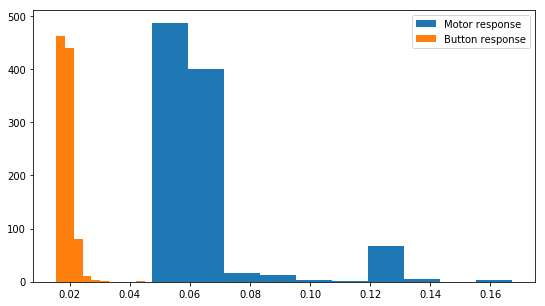

In [23]:
reactmean=sum(reactlist)/len(reactlist)
reactsecondmom=sum([val**2 for val in reactlist])/len(reactlist)
reactvar=reactsecondmom-reactmean**2

motor_without_sensor=[x-reactmean for x in motorreactlist]
motormean=sum(motor_without_sensor)/len(motor_without_sensor)
motorreactsecondmom=sum([val**2 for val in motor_without_sensor])/len(motor_without_sensor)
motorreactvar=motorreactsecondmom-motormean**2
print("mean motor response:",motormean)
print("motor response variance:",motorreactvar)
print("95% percentile motor response time:",np.percentile(motor_without_sensor,95))
print("mean button response:",reactmean)
print("button response variance:",reactvar)
print("95% percentile button response time:",np.percentile(reactlist,95))

fig=plt.figure(figsize=(9, 5))
plt.hist(motor_without_sensor,label="Motor response")
plt.hist(reactlist,label="Button response")
plt.legend()
plt.show()

In [13]:
sum(motorreactlist)

84.72178950994203

Sensor reaction speeds are generally quick, below 0,02 seconds, and the time distribution is not worrying. Motor reaction speeds (minus average button speed) show a similar pattern, but slightly slower. 95% of the observed motor reaction speeds were below 0,124 seconds.  
Colour reaction speeds are as expected of a normal sensor. In the below code, "colour" refers to observed colour, abient light and reflected light, where "rgb" only refers to observed colour

In [16]:
with open("color_delay_all.pkl","rb") as file:
    color_delay          = pickle.load(file)
with open("color_delay_rgb_only.pkl","rb") as file:
    color_delay_rgb_only = pickle.load(file)
    

In [28]:
colourmean=sum(color_delay)/len(color_delay)
coloursecondmom=sum([val**2 for val in color_delay])/len(color_delay)
colourvar=coloursecondmom-colourmean**2
rgbmean=sum(color_delay_rgb_only)/len(color_delay_rgb_only)
rgbsecondmom=sum([val**2 for val in color_delay_rgb_only])/len(color_delay_rgb_only)
rgbvar=rgbsecondmom-rgbmean**2


print("mean colour response:",colourmean)
print("colour response variance:",colourvar)
print("95% percentile colour response time:",np.percentile(color_delay,95))
print("mean rgb response:",rgbmean)
print("rgb response variance:",rgbvar)
print("95% percentile rgb response time:",np.percentile(color_delay_rgb_only,95))


mean colour response: 0.22751678050465285
colour response variance: 0.00038331602385920094
95% percentile colour response time: 0.25840986494728213
mean rgb response: 0.062080969867517294
rgb response variance: 0.0001074491998927841
95% percentile rgb response time: 0.07739746994968755


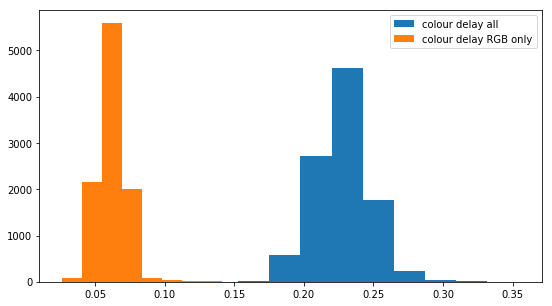

In [24]:
fig=plt.figure(figsize=(9, 5))
plt.hist(color_delay,label="colour delay all")
plt.hist([ele for ele in color_delay_rgb_only],label="colour delay RGB only") # try ele*3
plt.legend()
plt.show()